# ATSC 409 Assignment 05

##Problem Constant:

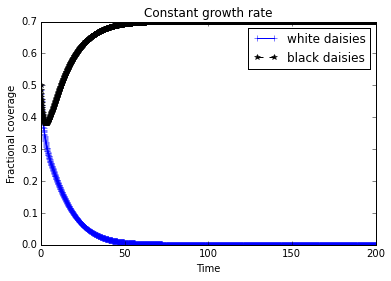

In [127]:
%matplotlib inline
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

class Integ51(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None
    #
    # Construct an Integ51 class by inheriting first intializing
    # the parent Integrator class (called super).  Then do the extra
    # initialization in the set_yint function
    #
    def __init__(self, coeffFileName):
        super().__init__(coeffFileName)
        self.set_yinit()

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           
           Constant growty rates for white
           and black daisies beta_w and beta_b
           
           returns dy/dt
        """
        user = self.uservars
        #
        # bare ground
        #
        x = 1.0 - y[0] - y[1]

        # growth rates don't depend on temperature
        beta_b = 1  # growth rate for black daisies
        beta_w = 0.7
        # growth rate for white daisies

        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty([self.nvars], 'float')
        f[0] = y[0] * (beta_w * x - user.chi)
        f[1] = y[1] * (beta_b * x - user.chi)
        return f

theSolver = Integ51('fixed_growth.yaml')
timeVals, yVals, errorList = theSolver.timeloop5fixed()

plt.close('all')
thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(timeVals, yVals)
theLines[0].set_marker('+')
theLines[1].set_linestyle('--')
theLines[1].set_color('k')
theLines[1].set_marker('*')
theAx.set_title('Constant growth rate')
theAx.set_xlabel('Time')
theAx.set_ylabel('Fractional coverage')
theAx.legend(theLines, ('white daisies', 'black daisies'), loc='best')

1. For the given set of growth rates beta_w = beta_b = 0.7, non-zero steady states are achieved always regardless of the initial conditions.
2. For the given set of initial conditions whiteconc = blackconc = 0.5, non-zero steady states are achieved when the growth rates are greater than the death rate. If the growth rates are equal to each other and are greater than the death rate, then both white and black daisy populations reach non-zero steady states. If the growth rates are not equal to each other and at least one is greater than the death rate, then the population with the higher growth rate reaches non-zero steady state while the other population reaches zero steady-state. If both growth rates are less than the death rate, then both white and black daisy populations reach zero steady states. The same phenomenon applies to the set of initial conditions whiteconc = blackconc = 0.2, which is below the death rate.

##Problem Coupling:

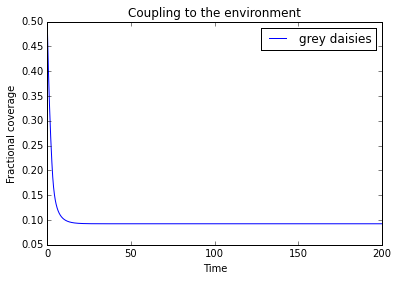

In [134]:
import numlabs.lab5.lab5_funs
from numlabs.lab5.lab5_funs import Integrator
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

class IntegCoupling(Integrator):
    """rewrite the init and derivs5 methods to
       work with a single (grey) daisy
    """

    def set_yinit(self):
        #
        # read in 'albedo_grey chi S0 L  R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'greyconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array([self.initvars.greyconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeffFileName):
        super().__init__(coeffFileName)
        self.set_yinit()

    def derivs5(self, y, t):
        """
           Make the growth rate depend on the ground temperature
           using the quadratic function of temperature

           y[0]=fraction grey daisies
           t = time
           returns f[0] = dy/dt
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        x = 1.0 - y[0]
        albedo_p = x * user.albedo_ground + y[0] * user.albedo_grey
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        eta = user.R *user.L * user.S0 / (4.0 * sigma)
        temp_y = (eta * (albedo_p - user.albedo_grey) + Te_4)**0.25
        if(temp_y >= 277.5 and temp_y <= 312.5):
            beta_y = 1.0 - 0.003265 * (295.0 - temp_y)**2.0
        else:
            beta_y = 0.0

        # create a 1 x 1 element vector to hold the derivative
        f = np.empty([self.nvars], np.float64)
        f[0] = y[0] * (beta_y * x - user.chi)
        return f

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

theSolver = IntegCoupling('coupling.yaml')
timeVals, yVals, errorList = theSolver.timeloop5fixed()

thefig, theAx = plt.subplots(1, 1)
theLines = theAx.plot(timeVals, yVals)
theAx.set_title('Coupling to the environment')
theAx.set_xlabel('Time')
theAx.set_ylabel('Fractional coverage')
out=theAx.legend(theLines, ('grey daisies',), loc='best')

1. The final steady state is zero for L = 0.2 because L affects the local temperature, which in turn impacts the growth rate of the daisy population. Based on the equations for temperature and growth rate, low values of L lead to low temperatures, which then lead to zero growth rate.
2. A value for L which leads to a non-zero steady state is 0.6.
3. As the fraction of sunlight received at Daisyworld L increases, the mean temperature of the planet Te increases.
4. Local temperature is highly dependent on the emission temperature. If perfect heat conduction exists, then there is no difference between local temperature and emission temperature. Otherwise, local temperature is a variation of emission temperature and therefore the two are not the same.
5. The makeup of the global daisy population affects the local temperature through the albedo-temperature feedback mechanism. Since local temperature differs according to the albedo of the region, then the global daisy population dictates the albedo of most of the planet, which then dictates the amount of solar radiation received by most of the planet. Consequently, this impacts local temperatures across majority of the planet.

##Problem Initial:

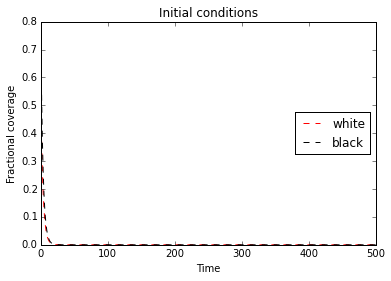

In [181]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class Integ54(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi)
        f[1] = y[1] * (beta_b * bare - user.chi)
        return f

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

theSolver = Integ54('initial.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
theAx.set_title('Initial conditions')
theAx.set_xlabel('Time')
theAx.set_ylabel('Fractional coverage')
out=theAx.legend(loc='center right')

1. Adding a small initial fraction of black daisies causes a slight deviation from zero steady state for the black daisy population. This small added fraction also increases the local temperature by a bit.
2. The initial white daisy population doesn't need to be adjusted to obtain a non-zero steady state; it already does! Decreasing the initial fraction gives zero steady state while increasing it gives non-zero steady state. As the initial fraction is increased, the planetary albedo alpha_p grows as well, driving the local temperature and growth rate upwards.
3. If the initial white daisy population is less than or equal to the initial black daisy population, then both daisy populations reach a zero steady state regardless of the initial black daisy population; interestingly, vice versa doesn't work. This may be due to the fact that albedo_white is so much larger than albedo_black that the white daisy population dominates the global daisy population. Also, the black daisy population never reaches a steady state at a value greater than 0.1 given any starting black or white daisy populations. 

##Problem Temperature:

In [ ]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class Integ54(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi)
        f[1] = y[1] * (beta_b * bare - user.chi)
        return f

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

theSolver = Integ54('initial.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
theAx.set_title('Initial conditions')
theAx.set_xlabel('Time')
theAx.set_ylabel('Fractional coverage')
out=theAx.legend(loc='center right')

##Problem Estimate:

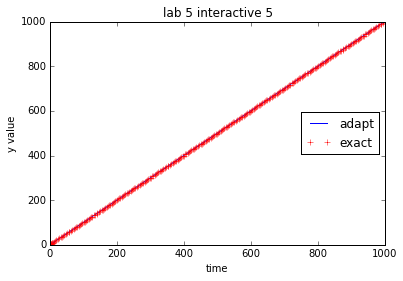

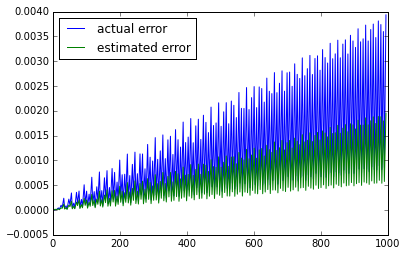

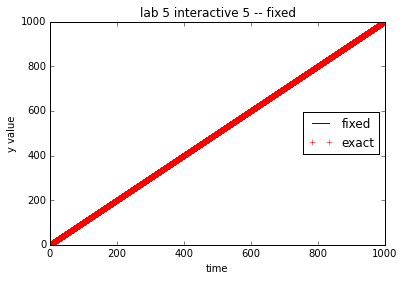

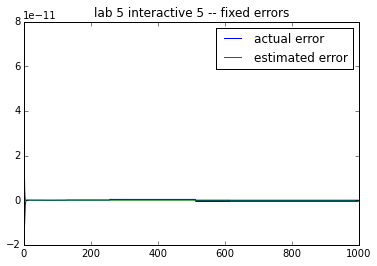

In [199]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class Integ55(Integrator):

    def set_yinit(self):
        #
        # read in 'c1 c2 c3'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in initial yinit
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array([self.initvars.yinit])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def derivs5(self, y, theTime):
        """
           y[0]=fraction white daisies
        """
        user=self.uservars
        f=np.empty_like(self.yinit)
        f[0]=user.c1*y[0] + user.c2*theTime + user.c3;
        return f

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

theSolver=Integ55('expon.yaml')

timeVals,yVals,yErrors =theSolver.timeloop5Err()
timeVals=np.array(timeVals)
exact=timeVals + np.exp(-timeVals)
yVals=np.array(yVals)
yVals=yVals.squeeze()
yErrors=np.array(yErrors)

thefig,theAx=plt.subplots(1,1)
line1=theAx.plot(timeVals,yVals,label='adapt')
line2=theAx.plot(timeVals,exact,'r+',label='exact')
theAx.set_title('lab 5 interactive 5')
theAx.set_xlabel('time')
theAx.set_ylabel('y value')
theAx.legend(loc='center right')

#
# we need to unpack yvals (a list of arrays of length 1
# into an array of numbers using a list comprehension
#

thefig,theAx=plt.subplots(1,1)
realestError = yVals - exact
actualErrorLine=theAx.plot(timeVals,realestError,label='actual error')
estimatedErrorLine=theAx.plot(timeVals,yErrors,label='estimated error')
theAx.legend(loc='best')


timeVals,yVals,yErrors =theSolver.timeloop5fixed()

np_yVals=np.array(yVals).squeeze()
yErrors=np.array(yErrors)
np_exact=timeVals + np.exp(-timeVals)


thefig,theAx=plt.subplots(1,1)
line1=theAx.plot(timeVals,np_yVals,label='fixed')
line2=theAx.plot(timeVals,np_exact,'r+',label='exact')
theAx.set_title('lab 5 interactive 5 -- fixed')
theAx.set_xlabel('time')
theAx.set_ylabel('y value')
theAx.legend(loc='center right')

thefig,theAx=plt.subplots(1,1)
realestError = np_yVals - np_exact
actualErrorLine=theAx.plot(timeVals,realestError,label='actual error')
estimatedErrorLine=theAx.plot(timeVals,yErrors,label='estimated error')
theAx.legend(loc='best')
theAx.set_title('lab 5 interactive 5 -- fixed errors')

1. In the adaptive step-size solution, the estimated error always underestimates the actual error. Even if the estimated error and the actual error both follow an oscillatory behavior, there is little overlap between the two, making the estimated error an unreasonable estimate of the actual error. However in the fixed step-size solution, there is little to no difference between actual error and estimated error and both follow a stable non-oscillatory behavior; therefore the error estimate is reasonable.
2. In the adaptive step-size solution, decreasing the time step causes the error estimate to diverge from the computed error because In the fixed step-size solution however, decreasing the time step makes no difference.
3. In the adaptive step-size solution, increasing the time step still causes the error estimate to diverge from the computed error. In the fixed step-size solution however, increasing the time step causes the error estimate to grow exponentially in magnitude. 